<a href="https://colab.research.google.com/github/RudkovYaroslav/graduation_project/blob/main/graduation_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Проект "Телеком" Поиск клиентов с неоптимальным тарифом

Телеком-провайдер «Нупозвони» ищет аналитиков! Мы хотим помочь колл-центрам найти неэффективных операторов, а также предложить им самые выгодные тарифы.

__Цели исследования__:
 - Найти клиентов, которые переплачивают на текущих тарифах
 - Найти клиентов, которые сэкономят, если перейдут на болеее дорогой тариф

Ход исследования

Я получу данные из датафреймов, которые находится в csv файле. О качестве этих DataFrame пока ничего не известно, так что, скорее всего, понадобится провести предобработку.

Проверю данные на аномалии и выбросы, которые могут повлиять на исследование, заполню пропуски, если они имеются, и в целом поищу возможность исправить все ошибки, которые не приведут к искажению конечного результата.

Итоговое исследование пройдет в 5 этапов:

 - Обзор данных
 - Предобработка данных
 - Исследовательский анализ
 - Статистический анализ
 - Общий вывод

## Обзор данных

### Импортируем нужные библиотеки и зададим некоторые стандартные параметры:

In [ ]:
import pandas as pd # Оснвная библиотека для работы с DataFrame
import seaborn as sns # Библиотека для построения более продвинутых графиков
import matplotlib.pyplot as plt # Библиотека для построения базовых графиков и задачи им параметров
import math # Библиотека для математических формул
plt.rcParams["figure.figsize"] = (15,5) #Задаем изначальный размер для всех графиков
import numpy as np # Еще одна математическая библиотека python
import scipy.stats as stats # Библиотека для работы с математической статистикой
from scipy.stats import mannwhitneyu # Конкретно тест Манна-Уитни
import statistics # Для использования методов статистики
import warnings
warnings.filterwarnings('ignore')

### Считаем файлы:

In [ ]:
clients = pd.read_csv('https://code.s3.yandex.net/datasets/telecom_clients.csv')
display(clients.head())
clients.info()
print(f'Количество дубликатов - {clients.duplicated().sum()}')

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB
Количество дубликатов - 0


In [ ]:
dataset = pd.read_csv('https://code.s3.yandex.net/datasets/telecom_dataset.csv')
display(dataset.head())
dataset.info()
print(f'Количество дубликатов - {dataset.duplicated().sum()}')

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB
Количество дубликатов - 4900


### Вывод по разделу 1:

Рассмотрели данные "на глаз". Видно, что есть пропуски в данных. По типам данных все также не идеально. Присутствуют дубликаты. Время приступать к предобработке.

## Предобработка данных

При первом взгляде на данные есть несколько вещей, которые нужно поправить:

### Типы данных

У нас есть столбец с датой, приведем его к правильному отображению

In [ ]:
dataset.date = pd.to_datetime(dataset.date).apply(lambda x: x.replace(tzinfo=None))

In [ ]:
dataset.date.max() - dataset.date.min()

Timedelta('118 days 00:00:00')

In [ ]:
display(dataset.date.max())
dataset.date.min()

Timestamp('2019-11-28 00:00:00')

Timestamp('2019-08-02 00:00:00')

Мы располагаем периодом в 118 дней, который начинается со 2 агуста и идет до 28 ноября

### Дубликаты

In [ ]:
dataset[dataset.duplicated()]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
8,166377,2019-08-05,out,False,880020.0,True,8,0,50
28,166377,2019-08-12,in,False,NaN,True,2,0,34
44,166377,2019-08-14,out,False,880026.0,False,10,1567,1654
45,166377,2019-08-14,in,False,NaN,True,1,0,3
51,166377,2019-08-15,out,False,880026.0,False,11,1413,1473
...,...,...,...,...,...,...,...,...,...
53869,168601,2019-11-25,in,False,952914.0,False,7,1229,1282
53874,168601,2019-11-26,in,False,952914.0,False,4,539,562
53875,168601,2019-11-26,in,False,NaN,True,3,0,35
53885,168603,2019-11-20,out,False,959118.0,True,3,0,89


У нас есть некоторое количество дубликатов(4900). Так как мы не имеем информации о том, что это верные данные, то изначально будем предполагать, что результаты из каких-то источников просто задвоились. Избавимся от повторных значений

In [ ]:
dataset = dataset.drop_duplicates()

Также поищем неявные дубликаты

In [ ]:
len(dataset[(dataset[['date',
                      'direction',
                      'internal',
                      'operator_id',
                      'is_missed_call']].duplicated()) & (~dataset['operator_id'].isna())])

0

Их нет

### Пропуски

Ранее мы заметили, что пропуски есть в стобце internal, а также operator_id

In [ ]:
dataset.internal.value_counts()

False    43239
True      5653
Name: internal, dtype: int64

Так как количество пропусков очень мало в столбце internal, то заменим их все на False, так как куда бОльший шанс, что будет именно этот показатель.

In [ ]:
dataset.internal = dataset.internal.fillna(False)

В столбце operator_id уже куда больше пропусков. Нам нужны эти данные, так что заменим пропуски на Unknown - таким образом этот оператор будет использоваться при подсчете месячного чека и мы не сильно потеряем в качестве данных

In [ ]:
dataset.operator_id = dataset.operator_id.fillna('Unknown')

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49002 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              49002 non-null  int64         
 1   date                 49002 non-null  datetime64[ns]
 2   direction            49002 non-null  object        
 3   internal             49002 non-null  bool          
 4   operator_id          49002 non-null  object        
 5   is_missed_call       49002 non-null  bool          
 6   calls_count          49002 non-null  int64         
 7   call_duration        49002 non-null  int64         
 8   total_call_duration  49002 non-null  int64         
dtypes: bool(2), datetime64[ns](1), int64(4), object(2)
memory usage: 3.1+ MB


Как видим, пропусков больше нет

### Поиск аномальных значений

#### __Calls_count__

In [ ]:
display(f'Максимальное значение в столбце calls_count = {dataset["calls_count"].max()}')
display(f'Минимальное значение в столбце calls_count = {dataset["calls_count"].min()}')

'Максимальное значение в столбце calls_count = 4817'

'Минимальное значение в столбце calls_count = 1'

Значения действительно большие присутствуют в датафрейме. Визуализируем их для простоты

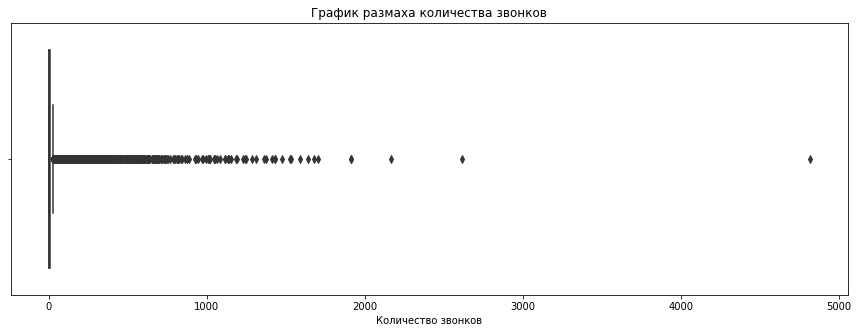

In [ ]:
sns.boxplot(x='calls_count', data=dataset, color='#238b45')
plt.title('График размаха количества звонков')
plt.xlabel('Количество звонков')
plt.show()

Большинство клиентов находятся в левой части, которую мы даже не можем увидеть из-за аномальных значений(4817 звонков за день от одного оператора думаю, можно считать аномальным)

Посмотрим, сколько уберется значений, если мы используем чистку с помощью 95 перцентиля:

In [ ]:
"{:.2%}".format(((dataset.loc[dataset['calls_count'] > dataset['calls_count'].quantile(0.95), 'calls_count'].count()
                                                                                            / dataset['calls_count'].count())))

'4.96%'

У нас уйдет около 5% данных, но каким тогда будет потолок количества звонков?

In [ ]:
dataset['calls_count'].quantile(0.95)

62.0

62 звонка. Это уже куда больше похоже на количество, которое один оператор обрабатывает в день

In [ ]:
dataset = dataset.drop(index=dataset.loc[dataset['calls_count'] > dataset['calls_count'].quantile(0.95)].index)

Придется пожертвовать таким немалым количеством данных для того, чтобы общее представление о них было более полным

### Call_duration и Total_call_duration

Посмотрим на эти два столбца вместе, так как они взаимосвязаны

In [ ]:
display(f'Максимальное значение в столбце call_duration = {dataset["call_duration"].max()}')
display(f'Минимальное значение в столбце call_duration = {dataset["call_duration"].min()}')

'Максимальное значение в столбце call_duration = 26175'

'Минимальное значение в столбце call_duration = 0'

In [ ]:
display(f'Максимальное значение в столбце total_call_duration = {dataset["total_call_duration"].max()}')
display(f'Минимальное значение в столбце total_call_duration = {dataset["total_call_duration"].min()}')

'Максимальное значение в столбце total_call_duration = 26347'

'Минимальное значение в столбце total_call_duration = 0'

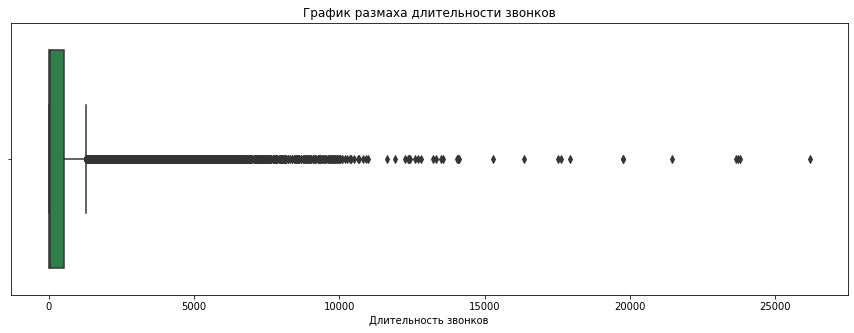

In [ ]:
sns.boxplot(x='call_duration', data=dataset, color='#238b45')
plt.title('График размаха длительности звонков')
plt.xlabel('Длительность звонков')
plt.show()

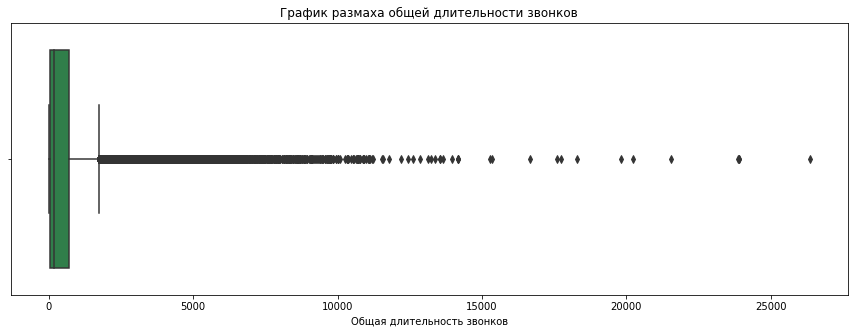

In [ ]:
sns.boxplot(x='total_call_duration', data=dataset, color='#238b45')
plt.title('График размаха общей длительности звонков')
plt.xlabel('Общая длительность звонков')
plt.show()

Видим, что столкнулись с серьезной проблемой. У нас в таблице представлена информация о каждом конкретном __Операторе__, который работает __1 день__. Соответственно, он не может физически разговаривать больше, чем __60 миунт * 24 часа = 1440__(И все еще это тоже достаточно обширное допущение, все же человеку нужен перерыв или сон, но мы опустим это).

У нас есть данные, которые противоречат этому. Сделаем допущение, что в столбце total_count_duration такие цифры вышли из-за того, что у оператора несколько телефонов, которые звонят одновременно, но вот уже разговаривать он не может сразу с несколькими абонентами, значит поставим фильтр по столбцу call_duration

In [ ]:
"{:.2%}".format(((dataset.loc[dataset['call_duration'] > 1440, 'call_duration'].count()
                                                                                            / dataset['call_duration'].count())))

'11.81%'

Мы лишаемся около 12% данных, поступая таким образом. Хоть это достаточно справедливо с учетом условия, но мы просто не можем так сделать, так как полнота данных исказится. Поступим по-старому и отсечем 5% данных

In [ ]:
"{:.2%}".format(((dataset.loc[dataset['call_duration'] > dataset['call_duration'].quantile(0.95), 'call_duration'].count()
                                                                                            / dataset['call_duration'].count())))

'5.00%'

In [ ]:
dataset = dataset.drop(index=dataset.loc[dataset['call_duration'] > dataset['call_duration'].quantile(0.95)].index)

Для столбца total_count_duration подобной операции делать не нужно, так как столбы взаимосвязаны

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44242 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              44242 non-null  int64         
 1   date                 44242 non-null  datetime64[ns]
 2   direction            44242 non-null  object        
 3   internal             44242 non-null  bool          
 4   operator_id          44242 non-null  object        
 5   is_missed_call       44242 non-null  bool          
 6   calls_count          44242 non-null  int64         
 7   call_duration        44242 non-null  int64         
 8   total_call_duration  44242 non-null  int64         
dtypes: bool(2), datetime64[ns](1), int64(4), object(2)
memory usage: 2.8+ MB


Много данных отсеялось во время предобработки. От изначальных 53902 осталось 44242. В итоге будем работать с около 82% от всех данных(Мы еще не взяли в расчет, что под исследование подходят только 2 месяца из четырех, так как только они полные)

### Объединим таблицы

In [ ]:
df = dataset.merge(clients, on='user_id')

Проверим, правильно ли объединились таблицы:

In [ ]:
len(df) == len(dataset)

True

In [ ]:
df.tariff_plan.unique()

array(['B', 'C', 'A'], dtype=object)

Объединение прошло успешно. Ни одна строка не исчезла и ни у одного клиента не потерялся тариф

Проверим, что ни один из клиентов не пришел позже своего первого действия

In [ ]:
df[df['date_start'] > df['date']]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start


Значит с этим в данных проблем нет

### Вывод по разделу 2:

Провели предобработку данных. В ее ходе:
 - Привели данные к правильным типам
 - Удалили явные дубликаты, посмотрели на неявные, не обнаружили их
 - Разобрались с пропусками
 - Провели большую работу над аномальными значениями. Пришлось отбросить около 25% данных, но они лишь навредили бы исследованию
 - Создали общую таблицу из исходных датафреймов

## Исследовательский анализ

### Соотношение тарифов

Для начала взглянем на данные более глубоко. Посмотрим, какое у нас процентное соотношение по тарифам

In [ ]:
table_for_viz = df.groupby('tariff_plan', as_index=False).user_id.nunique()

Перед постройкой первого графика создадим словарь цветов, чтобы все время была одна и та же палитра у каждого последующего графика:

In [ ]:
palette_colors = {
    'A' : '#238b45',
    'B' : '#3CB371',
    'C' : '#c7e9c0'
}

In [ ]:
def func(pct, allvalues):
    """ Эта функция правильно готовит значения для вывода

    Для построения графиков нужны и абсолютные и относительные значения
    Функция принимает их на вход и выводит в красивом формате, пригодном
    для визуализации
    """
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

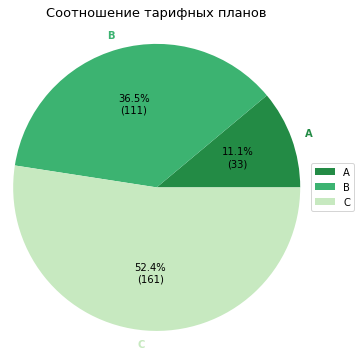

In [ ]:
fig, ax = plt.subplots()
patches, texts, pcts = ax.pie('user_id',
                              labels='tariff_plan',
                              data = table_for_viz,
                              autopct=lambda pct: func(pct, table_for_viz['user_id']),
                              radius = 1.2,
                              colors=[palette_colors[cat] for cat in table_for_viz['tariff_plan']])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for i, patch in enumerate(patches):
    texts[i].set_color(patch.get_facecolor())
fig.set_size_inches(10.5, 5.5)
plt.setp(pcts, color='black')
plt.setp(texts, fontweight=600)
plt.title('Соотношение тарифных планов', size=13, y=1.05)
plt.show()

Видим явное лидирование тарифа С, так как он самый дешевый. Тариф А находится в явном меньшинстве, что тоже достаточно объяснимо, так как он самый дорогой

### Длительность и количество звонков по тарифам

Посчитаем сколько раз клиенты всех тарифов звонят в день, а также как долго они это делают в среднем

In [ ]:
table_for_viz = df.groupby(['date', 'tariff_plan'], as_index=False).agg({'calls_count' : 'sum',
                                                               'total_call_duration' : 'sum'})

In [ ]:
table_for_viz = table_for_viz.groupby('tariff_plan', as_index=False).agg({'calls_count' : ['mean', 'median'],
                                                               'total_call_duration' : ['mean', 'median']})

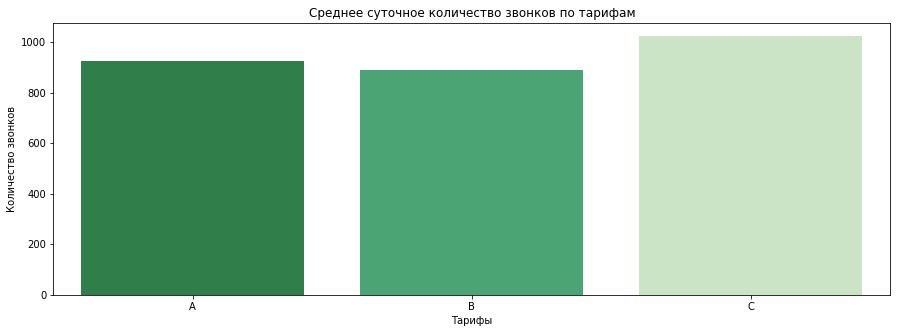

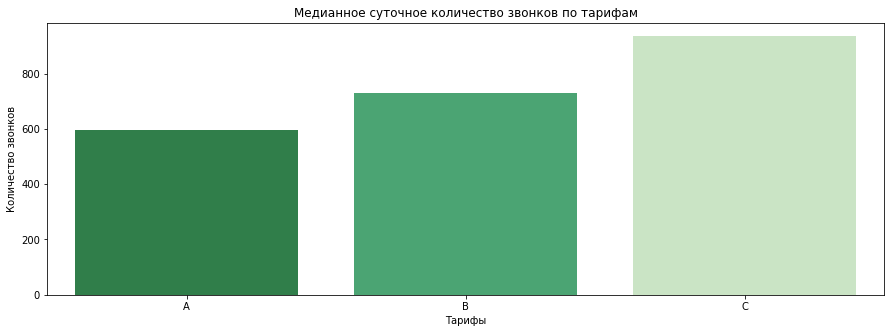

In [ ]:
sns.barplot(x=table_for_viz['tariff_plan'], y=table_for_viz['calls_count']['mean'], palette=palette_colors)
plt.title('Среднее суточное количество звонков по тарифам')
plt.xlabel('Тарифы')
plt.ylabel('Количество звонков')
plt.show()
sns.barplot(x=table_for_viz['tariff_plan'], y=table_for_viz['calls_count']['median'], palette=palette_colors)
plt.title('Медианное суточное количество звонков по тарифам')
plt.xlabel('Тарифы')
plt.ylabel('Количество звонков')
plt.show()

Получается, что звонят больше клиентов тарифа С в сутки. И по медиане и по среднему

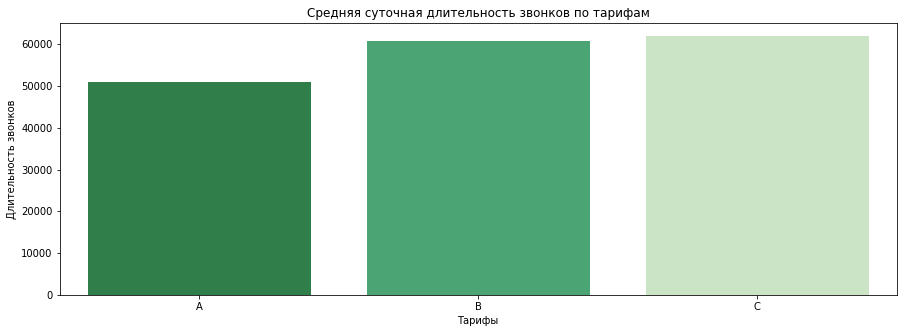

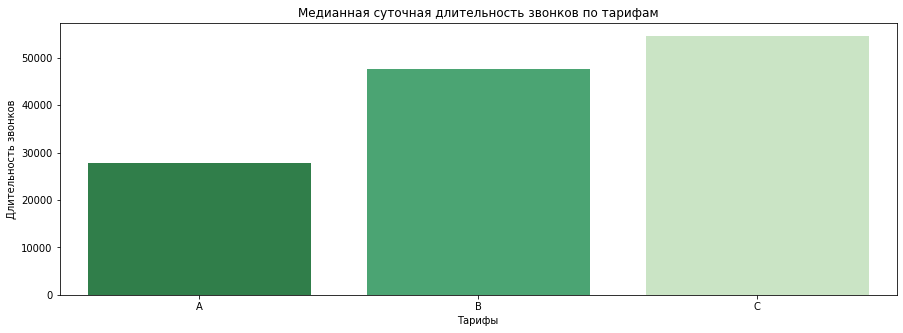

In [ ]:
sns.barplot(x=table_for_viz['tariff_plan'], y=table_for_viz['total_call_duration']['mean'], palette=palette_colors)
plt.title('Средняя суточная длительность звонков по тарифам')
plt.xlabel('Тарифы')
plt.ylabel('Длительность звонков')
plt.show()
sns.barplot(x=table_for_viz['tariff_plan'], y=table_for_viz['total_call_duration']['median'], palette=palette_colors)
plt.title('Медианная суточная длительность звонков по тарифам')
plt.xlabel('Тарифы')
plt.ylabel('Длительность звонков')
plt.show()

Этот график куда более интересен, потому что привязан напрямую к месячному чеку. Получается, что клиенты на тарифах С звонят куда больше, чем даже клиенты на тарифе А. Это как раз может служить одним из факторов того, что они используют невыгодный для них тариф

### Создание агрегированной таблицы по клиентам

Одна из ключевых задач - собрать все данные по клиентам, чтобы посчтитать их месячный чек

In [ ]:
def searching_for_in(row):
    """ Эта функция помогает избавиться от внутренних звонков

    Она ищет все строки, где есть in в столбце direction и затем
    меняет цифру в total_call_duration на 0, чтобы мы не использовали
    эти звонки в расчете месячного чека
    """
    if row['direction'] == 'in':
        row ['total_call_duration'] = 0
        return row
    else:
        return row

In [ ]:
df = df.apply(searching_for_in, axis=1)

In [ ]:
df.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start
0,166377,2019-08-04,in,False,Unknown,True,2,0,0,B,2019-08-01
1,166377,2019-08-05,out,True,880022.0,True,3,0,5,B,2019-08-01
2,166377,2019-08-05,out,True,880020.0,True,1,0,1,B,2019-08-01
3,166377,2019-08-05,out,True,880020.0,False,1,10,18,B,2019-08-01
4,166377,2019-08-05,out,False,880022.0,True,3,0,25,B,2019-08-01


Можно увидеть, что функция работает

Далее мы создадим два столбца, в которых будем считать исходящие внутренние звонки и исходящие внешние(Они нам пригодятся для подсчета)

In [ ]:
df['out_internal'] = df.apply(lambda x: x['total_call_duration'] if x['internal'] == True else 0, axis=1)

In [ ]:
df['out_not_internal'] = df.apply(lambda x: x['total_call_duration'] if x['internal'] != True else 0, axis=1)

Пере тем, как создать общую таблицу, посмотрим на распределение по месяцам, чтобы понять, какие мы можем использовать

In [ ]:
table_for_viz = df.groupby([df['date'].dt.month]).calls_count.sum()

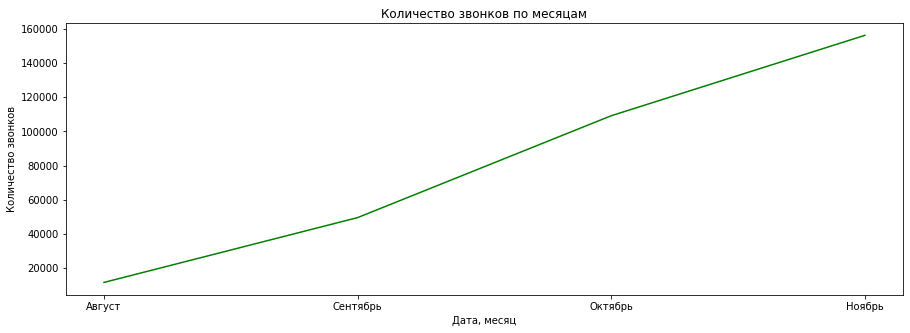

In [ ]:
sns.lineplot(x=table_for_viz.index, y=table_for_viz.values, color='Green')
plt.title('Количество звонков по месяцам')
plt.xlabel('Дата, месяц')
plt.ylabel('Количество звонков')
month_names = ['Август', 'Сентябрь', 'Октябрь', 'Ноябрь']
plt.xticks(table_for_viz.index, month_names)
plt.show()

И, также, посмотрим на доли:

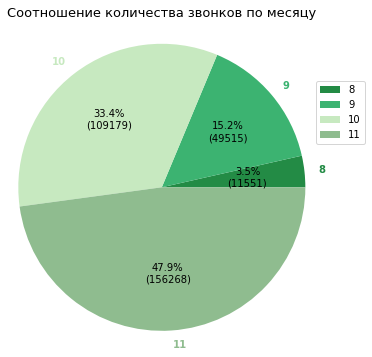

In [ ]:
fig, ax = plt.subplots()
patches, texts, pcts = ax.pie(table_for_viz.values,
                              labels=table_for_viz.index,
                              autopct=lambda pct: func(pct, table_for_viz.values),
                              radius = 1.2,
                              colors=['#238b45', '#3CB371', '#c7e9c0', '#8FBC8F'])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.75))
for i, patch in enumerate(patches):
    texts[i].set_color(patch.get_facecolor())
fig.set_size_inches(10.5, 5.5)
plt.setp(pcts, color='black')
plt.setp(texts, fontweight=600)
plt.title('Соотношение количества звонков по месяцу', size=13, y=1.05)
plt.show()

Видим, что за 8 месяц(август) звонков почти нет(меньше 4%), так что не будем тратить силы на расчеты по этому месяцу. А вот по остальным придется(__Важное замечание__ - в последнем месяце, ноябре, неполное количество дней. Подробнее - при расчете его месячного чека)

Затем, наконец, создадим общую таблицу. Будем создавать помесячно, так как нам еще надо будет ноябрь изменять

In [ ]:
client1_df = df[(df['date'] >= '2019-09') & (df['date']< '2019-10')].groupby('user_id').agg(
    operator_count = ('operator_id', 'count'),
    out_internal = ('out_internal', 'sum'),
    out_not_internal = ('out_not_internal', 'sum'),
    tariff_plan = ('tariff_plan', 'last'),
    calls_count = ('calls_count', 'sum'))

In [ ]:
client1_df.head()

,operator_count,out_internal,out_not_internal,tariff_plan,calls_count
user_id,,,,,
166377,153,9,102611,B,1430
166391,4,0,0,C,4
166392,17,0,0,C,36
166399,2,0,0,C,2
166405,172,0,70777,B,1315


В таблицу вошли:
 - Количество операторов
 - Общая сумма по времени исходящих внутренних звонков
 - Общая сумма по времени исходящих внешних звонков
 - Тарифный план
 - Общее количество звонков

Все это за месяц - сентябрь

### Поиск активных пользователей

Понятие - активный пользователь довольное размытое. Скорее всего ключевое поле для поиска - это calls_count

In [ ]:
table_for_viz = client1_df.groupby('calls_count', as_index=False).agg(num_of_calls = ('calls_count', 'count'))

In [ ]:
table_for_viz['calls_count'] = table_for_viz['calls_count'].apply(lambda x: math.log(x))

В визуализации будем использовать логарифм. Он хорошо покажет, что у нас происходит в начале, которое нас интересует больше всего, а также опустит длинный хвост в конце

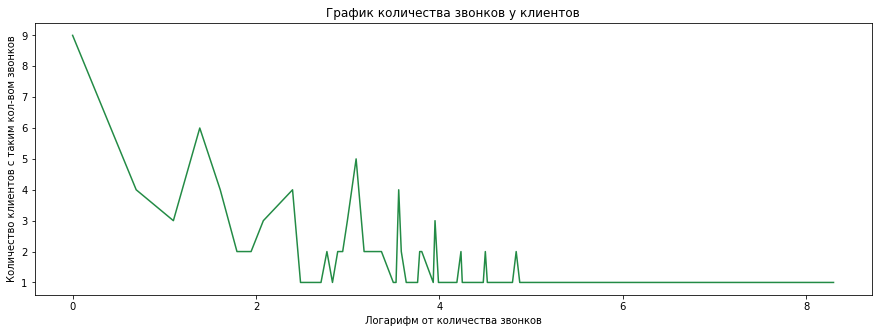

In [ ]:
sns.lineplot(x='calls_count', y='num_of_calls', data = table_for_viz, color='#238b45')
plt.title('График количества звонков у клиентов')
plt.xlabel('Логарифм от количества звонков')
plt.ylabel('Количество клиентов с таким кол-вом звонков')
plt.show()

На графике видно достаточно много клиентов в начале. У них где-то от 0 до log(2) = 8 звонков. Это, скорее всего, неактивные клиенты, так как мы говорим о целом месяце. На графике видно, что график становится более стабильным на отметке в ~2.75. Это около 16 звонков(Что, кстати, совпадает с 25 перцентилем) В целом, считаю, что будет справедливо ограничить клиентов этим параметром

In [ ]:
math.log(16)

2.772588722239781

In [ ]:
client1_df['calls_count'].quantile(0.25)

17.0

In [ ]:
client1_df = client1_df[client1_df['calls_count'] > client1_df['calls_count'].quantile(0.25)]

In [ ]:
def tarification(row):
    """ Эта функция занимается расчетом месячного чека

    Используя значения из условия она проводит вычисление на параметрах из агрегированной таблицы
    Сначала идет сравнение количества внутрнених исходящих звонков с нулем, чтобы понять,
    Вышел ли клиент за лимит, или нет. Затем эта переменная либо используется в уравнении, либо нет
    Сами вычисления тоже построены из условия
    """
    sum = 0
    if row['tariff_plan'] == 'A':
        if row['out_internal'] - 2000 < 0:
            row['out_internal'] == 0
        else:
            row['out_internal'] == row['out_internal'] - 2000
        sum = 4000 + row['out_internal'] * 0.1 + row['out_not_internal'] * 0.3 + row['operator_count'] * 50
    elif row['tariff_plan'] == 'B':
        if row['out_internal'] - 500 < 0:
            row['out_internal'] == 0
        else:
            row['out_internal'] == row['out_internal'] - 500
        sum = 2000 + row['out_internal'] * 0.15 + row['out_not_internal'] * 0.5 + row['operator_count'] * 150
    elif row['tariff_plan'] == 'C':
        sum = 1000 + row['out_internal'] * 0.3 + row['out_not_internal'] * 0.7 + row['operator_count'] * 300
    else:
        return 0
    return round(sum,1)

In [ ]:
client1_df['monthly_check'] = client1_df.apply(tarification, axis=1)

Наконец получили интересующую нас таблицу

In [ ]:
client1_df.head()

,operator_count,out_internal,out_not_internal,tariff_plan,calls_count,monthly_check
user_id,,,,,,
166377,153,9,102611,B,1430,76256.9
166392,17,0,0,C,36,6100.0
166405,172,0,70777,B,1315,63188.5
166406,97,28,42326,B,1230,37717.2
166407,110,5348,2350,A,215,10739.8


Теперь сделаем также с октябрем:

In [ ]:
client2_df = df[(df['date'] >= '2019-10') & (df['date']< '2019-11')].groupby('user_id').agg(
    operator_count = ('operator_id', 'count'),
    out_internal = ('out_internal', 'sum'),
    out_not_internal = ('out_not_internal', 'sum'),
    tariff_plan = ('tariff_plan', 'last'),
    calls_count = ('calls_count', 'sum'))
client2_df = client2_df[client2_df['calls_count'] > client2_df['calls_count'].quantile(0.25)]
client2_df['monthly_check'] = client2_df.apply(tarification, axis=1)

Сразу отфильтруем таблицу по 25 перцентилю и проведем вычисления

И с ноябрем:

In [ ]:
client3_df = df[(df['date'] >= '2019-11')].groupby('user_id').agg(
    operator_count = ('operator_id', 'count'),
    out_internal = ('out_internal', 'sum'),
    out_not_internal = ('out_not_internal', 'sum'),
    tariff_plan = ('tariff_plan', 'last'),
    calls_count = ('calls_count', 'sum'))

Вот только незадача, в ноябре не все дни. Мы эти данные получить не можем, а месяц для нас важный. Поступим так - разделим все значения на количество дней(28) и умножим на нужное количество дней (в ноябре их 30). Так мы хоть немного компенсируем недостаток в данных

In [ ]:
client3_df.head()

,operator_count,out_internal,out_not_internal,tariff_plan,calls_count
user_id,,,,,
166377,118,127,81640,B,1208
166391,3,0,0,C,3
166392,30,0,0,C,71
166405,269,115,118560,B,3312
166406,52,0,26762,B,720


До преобразования

In [ ]:
client3_df[['operator_count', 'out_internal', 'out_not_internal', 'calls_count']] = \
(client3_df[['operator_count', 'out_internal', 'out_not_internal', 'calls_count']].apply(lambda x: x / 28 * 30)).astype(int)

In [ ]:
client3_df.head()

,operator_count,out_internal,out_not_internal,tariff_plan,calls_count
user_id,,,,,
166377,126,136,87471,B,1294
166391,3,0,0,C,3
166392,32,0,0,C,76
166405,288,123,127028,B,3548
166406,55,0,28673,B,771


После преобразования. Выглядит все верно

In [ ]:
client3_df = client3_df[client3_df['calls_count'] > client3_df['calls_count'].quantile(0.25)]

In [ ]:
client3_df['monthly_check'] = client3_df.apply(tarification, axis=1)

In [ ]:
monthly_payment = pd.concat([client1_df, client2_df, client3_df])

Теперь получим итоговую таблицу по трем месяцам

In [ ]:
monthly_payment.head()

,operator_count,out_internal,out_not_internal,tariff_plan,calls_count,monthly_check
user_id,,,,,,
166377,153,9,102611,B,1430,76256.9
166392,17,0,0,C,36,6100.0
166405,172,0,70777,B,1315,63188.5
166406,97,28,42326,B,1230,37717.2
166407,110,5348,2350,A,215,10739.8


Осталось только снова сгруппировать ее по клиентам, чтобы у нас не затроились ответы:

In [ ]:
monthly_payment = monthly_payment.reset_index().groupby('user_id').agg({'operator_count' : lambda x: int(x.mean()),
                                                                        'out_internal' : lambda x: x.mean().astype(int),
                                                                        'out_not_internal' : lambda x: x.mean().astype(int),
                                                                        'tariff_plan' : 'first',
                                                                        'calls_count' : lambda x: x.mean().astype(int),
                                                                        'monthly_check' : lambda x: x.mean().astype(int)
})

In [ ]:
monthly_payment.head()

,operator_count,out_internal,out_not_internal,tariff_plan,calls_count,monthly_check
user_id,,,,,,
166377,138,50,95396,B,1366,70405.0
166392,27,0,0,C,61,9200.0
166399,13,0,0,C,16,4900.0
166405,234,300,91275,B,2535,82882.0
166406,79,280,34663,B,1046,31223.0


Все сработало нормально. Теперь у нас есть средние показатели по каждому клиенту за 3 месяца

### Поиск пользователей с неэффективным тарифами

Для этой задачи нам предстоит создать копию таблицы

In [ ]:
monthly_payment_alt = monthly_payment

In [ ]:
def rotation(cell):
    """ Эта функция "крутит" тарифные планы

    Чтобы мы рассмотрели все варианты тарифных планов клиентов, будем менять
    тарифные планы по часовой стрелке. Так, доупстим, вызвав функция 3 раза
    мы придем к исходным значениям
    """
    if cell == "B":
        return "A"
    elif cell == "C":
        return "B"
    else:
        return "C"

In [ ]:
monthly_payment_alt['tariff_plan'] = monthly_payment['tariff_plan'].apply(rotation)

In [ ]:
monthly_payment_alt.head()

,operator_count,out_internal,out_not_internal,tariff_plan,calls_count,monthly_check
user_id,,,,,,
166377,138,50,95396,A,1366,70405.0
166392,27,0,0,B,61,9200.0
166399,13,0,0,B,16,4900.0
166405,234,300,91275,A,2535,82882.0
166406,79,280,34663,A,1046,31223.0


Проверили, что функция работает, теперь мы можем посчитать чеки, если бы все пользователи поменяли тариф на один "выше"

In [ ]:
monthly_payment_alt['alt_monthly_check'] = monthly_payment_alt.apply(tarification, axis=1)

Осталось еще один раз сделать тоже самое

In [ ]:
monthly_payment_alt['tariff_plan'] = monthly_payment_alt['tariff_plan'].apply(rotation)

In [ ]:
monthly_payment_alt['alt_monthly_check_2'] = monthly_payment_alt.apply(tarification, axis=1)

Получили чеки, если бы все пользователи поменяли тариф на 2 "выше"

In [ ]:
monthly_payment_alt['tariff_plan'] = monthly_payment_alt['tariff_plan'].apply(rotation)

Возвращаем в исходное положение тарифы

In [ ]:
monthly_payment_alt.head()

,operator_count,out_internal,out_not_internal,tariff_plan,calls_count,monthly_check,alt_monthly_check,alt_monthly_check_2
user_id,,,,,,,,
166377,138,50,95396,B,1366,70405.0,39523.8,109192.2
166392,27,0,0,C,61,9200.0,6050.0,5350.0
166399,13,0,0,C,16,4900.0,3950.0,4650.0
166405,234,300,91275,B,2535,82882.0,43112.5,135182.5
166406,79,280,34663,B,1046,31223.0,18376.9,49048.1


Визуализируем полученную информацию:

Опишем алгоритм работы для простоты восприятия:
 - Мы создаем цикл, где перебираются 3 столбца с чеками
 - Затем, перебираясь построчно, мы смотрим, сколько раз конкретно этот столбец был самым выгодным для клиента
 - Ставя 1 и 0 в случаях успеха/неудачи, мы получаем таблицу. По ней строим диаграмму
 - Как проверку можно использовать сумму процентов, где получилось 1. В сумме должно быть 100(Возможно 101 или 99 из-за проблем округления)

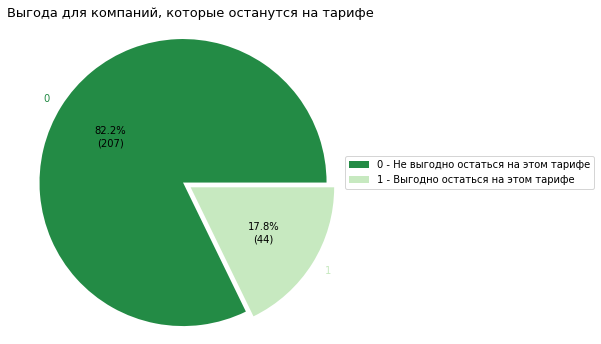

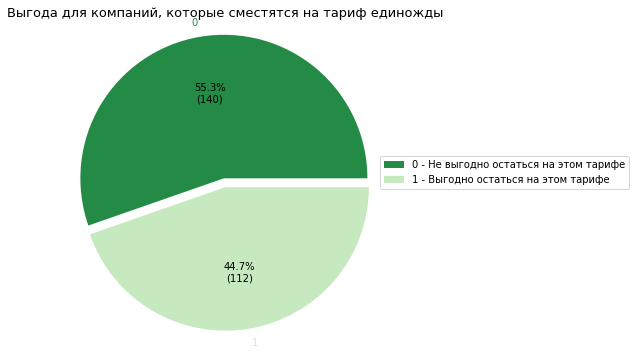

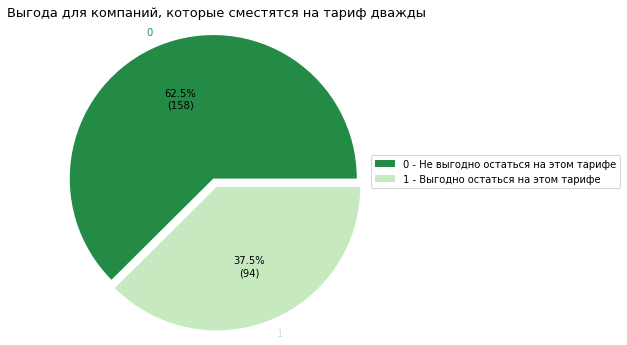

In [ ]:
for j, item in enumerate(['monthly_check', 'alt_monthly_check', 'alt_monthly_check_2']):
    monthly_payment_alt['column_for_viz'] = monthly_payment_alt.apply(lambda x: 1 if x[[
    'alt_monthly_check',                                     #Здесь мы используем lambda, чтобы понять, находится ли минимальное
    'monthly_check',                                         #значение в том столбце, который используется в цикле
    'alt_monthly_check_2']].min() == x[item] else 0, axis=1) #
    table_for_viz = monthly_payment_alt.groupby('column_for_viz', as_index=False).operator_count.count()
    fig, ax = plt.subplots()
    patches, texts, pcts = ax.pie('operator_count',
                              labels='column_for_viz',
                              data=table_for_viz,
                              autopct=lambda pct: func(pct, table_for_viz['operator_count']),
                              explode = (0.075, 0),
                              radius = 1.2,
                              colors=['#238b45', '#c7e9c0'])
    ax.legend(['0 - Не выгодно остаться на этом тарифе', '1 - Выгодно остаться на этом тарифе'],
              loc='center left', bbox_to_anchor=(1, 0.55))
    for i, patch in enumerate(patches):
        texts[i].set_color(patch.get_facecolor())
    fig.set_size_inches(5.5, 5.5)
    plt.setp(pcts, color='black')
    plt.setp(texts, fontweight=10)
    if j == 0:
        plt.title('Выгода для компаний, которые останутся на тарифе', size=13, y=1.05)
    else:
        plt.title(f'Выгода для компаний, которые сместятся на тариф {"единожды" if j == 1 else "дважды"}', size=13, y=1.05)
    plt.show()

Итак, у нас на руках, пожалуй, самая важная визуализация всего исследования. Распишем подробно все, что она показывает:
 - Лишь __18% клиентов__ выгодно __Остаться на текущем тарифе__
 - Большинству клиентов (__45%__) выгодно __Перейти на тариф "выше"__
 - Оставшемуся количеству клиентов (__37%__) выгодно __Перейти на два тарифа "выше"__

То есть на данный момент у нас складывается такая ситуация, что если мы не предложим клиентам перейти на другой тариф, то __82%!__ клиентов у нас используют свои тарифы __невыгодно__

### Подсчет затрат компании

Теперь создадим таблицу "выгоды" клиентов

Для полноты картины нам нужно снова разделить таблицы на мсеяцы, чтобы мы могли более точно посчитать средние значения

In [ ]:
monthly_payment['better_tariff'] = np.where(
    monthly_payment['alt_monthly_check'] < monthly_payment['alt_monthly_check_2'],
    monthly_payment['tariff_plan'].apply(rotation),
    monthly_payment['tariff_plan'].apply(rotation).apply(rotation)
)

In [ ]:
clients_benefit = monthly_payment[
    monthly_payment[['alt_monthly_check',
                         'monthly_check',
                         'alt_monthly_check_2']].min(axis=1) != monthly_payment['monthly_check']][['monthly_check',
                                                                                                       'alt_monthly_check',
                                                                                                       'alt_monthly_check_2',
                                                                                                        'tariff_plan',
                                                                                                        'better_tariff']]

In [ ]:
clients_benefit.head()

,monthly_check,alt_monthly_check,alt_monthly_check_2,tariff_plan,better_tariff
user_id,,,,,
166377,70405.0,39523.8,109192.2,B,A
166392,9200.0,6050.0,5350.0,C,A
166399,4900.0,3950.0,4650.0,C,B
166405,82882.0,43112.5,135182.5,B,A
166406,31223.0,18376.9,49048.1,B,A


В этой таблице собраны все клиенты, для которых выгодно перейти либо на один тариф, либо на два "выше"

Теперь с помощью нехитрых манипуляций оставим только столбец с изначальным чеком и столбец с самым выгодным чеком для клиента

In [ ]:
clients_benefit['alt_monthly_check'] = clients_benefit[[
    'alt_monthly_check',
    'monthly_check',
    'alt_monthly_check_2'
    ]].min(axis=1)

In [ ]:
clients_benefit = clients_benefit.drop(columns='alt_monthly_check_2')

Добавим стобец потерь компании от выгоды клиента

In [ ]:
clients_benefit['company_loss'] = clients_benefit['alt_monthly_check'] - clients_benefit['monthly_check']

In [ ]:
clients_benefit.head()

,monthly_check,alt_monthly_check,tariff_plan,better_tariff,company_loss
user_id,,,,,
166377,70405.0,39523.8,B,A,-30881.2
166392,9200.0,5350.0,C,A,-3850.0
166399,4900.0,3950.0,C,B,-950.0
166405,82882.0,43112.5,B,A,-39769.5
166406,31223.0,18376.9,B,A,-12846.1


По итогу у нас вышла __Интересующая заказчика таблица__ - clients_benefit. В ней собрана основная информация всего исследования

Далее идет экономический подсчет затрат:

In [ ]:
clients_benefit['company_loss'].sum()

-2967334.1000000006

В сумме вышло около __3 млн рублей__ в потерях в среднем за месяц. Стоит также учитывать тот факт, что это потери в идеальном мире, если _абсолютно каждый_ клиент(82% от общего числа) перейдет на выгодный для него тариф

Визуализируем потери компании:

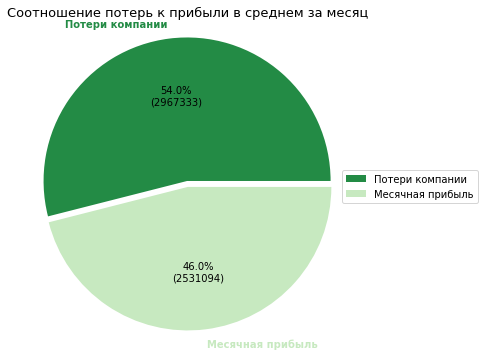

In [ ]:
fig, ax = plt.subplots()
patches, texts, pcts= ax.pie( labels=['Потери компании', 'Месячная прибыль'],
                              x = [abs(clients_benefit['company_loss'].sum()),
                                   clients_benefit['alt_monthly_check'].sum()],
                              autopct = lambda pct: func(pct, [abs(clients_benefit['company_loss'].sum()),
                                   clients_benefit['alt_monthly_check'].sum()]),
                              colors = ['#238b45','#c7e9c0'],
                              explode = (0.05,0),
                              radius = 1.2)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for i, patch in enumerate(patches):
    texts[i].set_color(patch.get_facecolor())
fig.set_size_inches(10.5, 5.5)
plt.setp(pcts, color='black')
plt.setp(texts, fontweight=600)
plt.title('Соотношение потерь к прибыли в среднем за месяц', size=13, y=1.05)
plt.show()

На графиках можно увидеть, что компания теряет больше, чем зарабатывает(Значения прибыли мы взяли уже с учетом перехода всех клиентов на более выгодный для них тариф)

In [ ]:
clients_benefit['alt_monthly_check'].sum()

2531093.9

Причем прибыль от этих клиентов покроет затраты примерно за __один месяц__. То есть, если рассматривать гипотетическую ситуацию, в которой компания может потерять всех этих клиентов(прибыль от них будет 0), то, как альтернатива, такие "потери" выглядят не такими серьезными.

In [ ]:
abs(clients_benefit['company_loss'].sum() / len(clients_benefit))

14266.029326923079

Также, для смягчения потерь, можно предложить оформить переход на другой тариф за определенную плату. Если предложить сумму в 14300, то компания будет даже в плюсе от такого

Но если все равно этого недостаточно, чтобы предпринять такой серьезный шаг, рассмотрим еще один вариант - предложить перейти не всем клиентам, а той группе, в которой находится большинство - то есть предложить перейти только тем, кому выгодно подняться на один тариф "выше"

In [ ]:
company_loss = monthly_payment['alt_monthly_check'] - monthly_payment['monthly_check']

In [ ]:
abs(company_loss[company_loss<0].sum())

2117197.0999999996

В таком случае компания потеряет лишь __2.1 млн рублей__ в среднем за месяц

### Выводы по разделу 3

Провели исследовательский анализ данных. Ответили на основные вопросы исследования, а также на некоторые дополнительные, которые могли появиться, при взгляде на данные:
 - По распределению клиентов по тарифным планам видим явное лидирование тарифа С, так как он самый дешевый. Тариф А находится в явном меньшинстве, что тоже достаточно объяснимо, так как он самый дорогой
 - Клиенты тарифов С звонят чаще и больше, чем даже клиенты на тарифе А. Это как раз может служить одним из факторов того, что они используют невыгодный для них тариф
 - Создали таблицу по пользователям, а также рассмотрели, как искать активных клиентов. Решением стало отделить нижний, 25-ый перцентиль. Это все клиенты, которые за месяц имели меньше 16 звонков
 - Также посмотрели на то, какому количеству пользователей было бы выгодно остаться, а каким переключиться. Оказалось, что:
   - Лишь __18% клиентов__ выгодно __Остаться на текущем тарифе__
   - Большинству клиентов (__45%__) выгодно __Перейти на тариф "выше"__
   - Оставшемуся количеству клиентов (__37%__) выгодно __Перейти на два тарифа "выше"__
 - А также пришли к выводу, что складывается такая ситуация, что если мы не предложим клиентам перейти на другой тариф, то __82%!__ клиентов у нас используют свои тарифы __невыгодно__
 - Создали итоговую таблицу, в которой мы можем найти идентификаторы всех клиентов, кому можно предложить переход и показали выгоду для каждого конкретного клиента
 - Затем рассчитали затраты компании в случае, если __каждый клиент__ перейдет на выгодный для него тариф - около __3 млн рублей__ в среднем за месяц
 - Были предложены варианты уменьшения этой суммы:
   - Оформлять переход за плату. При цене выше, чем 143000 руб., компания будет __в плюсе__
   - Предложить оформить переход только клиентам из самой популярной группы. В таком случае потери компании составят около __2.1 млн рублей__, но также для некоторых клиентов это __будет не самым выгодным предложением для них__

## Статистический анализ

### Проверка гиптоез

#### Гипотеза о среднем месячном чеке

$H_0$ Средний месячный чек клиента тарифа А и клиента тарифа B не имеет статистически значимых отличий

$H_1$ Средний месячный чек клиента тарифа А отличается от клиента тарифа B

Для проверки этой гипотезы хорошо подходит независимый t-test. Но для его проведения нужно посмотреть, как распределены данные.
Есть два способа, чтобы понять, распределены ли данные нормально: графический и нумерическийю Воспользуемся обоими. Сначала объединим наши данные

In [ ]:
data_A = monthly_payment[monthly_payment['tariff_plan'] == 'A']['monthly_check']
data_B = monthly_payment[monthly_payment['tariff_plan'] == 'B']['monthly_check']

__Первый способ - Q-plot__

Позволяет наглядно сравнить график с нормальным распределением

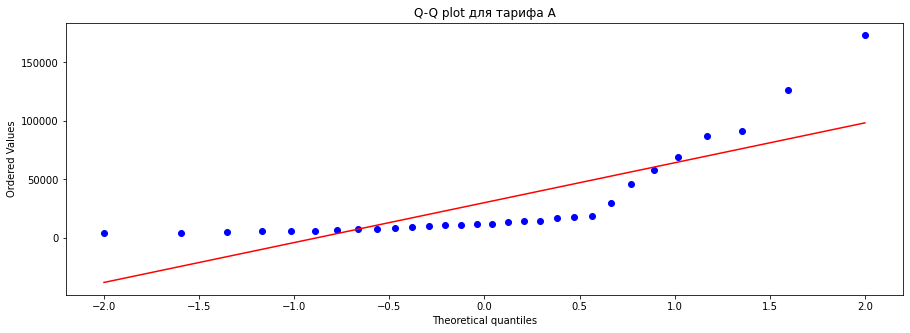

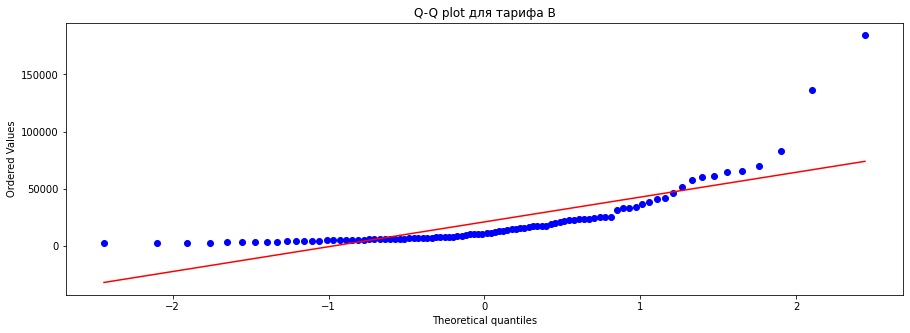

In [ ]:
stats.probplot(monthly_payment[monthly_payment['tariff_plan'] == 'A']['monthly_check'], dist="norm", plot=plt)
plt.title("Q-Q plot для тарифа A")
plt.show()
stats.probplot(monthly_payment[monthly_payment['tariff_plan'] == 'B']['monthly_check'], dist="norm", plot=plt)
plt.title("Q-Q plot для тарифа B")
plt.show()

Видим, что распределение достаточно далеко от того, какое на нужно. Также еще проверим на цифрах:

__Второй способ - Тест Шапиро-Уилка__

Тест Шапиро-Уилка хорошо покажет отклонение от нормального распределения. p-value, полученное в ходе теста должно быть больше 0.05

In [ ]:
stat_A, p_A = stats.shapiro(data_A)
print(f'Тест Шапиро-Уилка для тарифа A: p-значение = {p_A}')

Тест Шапиро-Уилка для тарифа A: p-значение = 3.6542289194585464e-07


In [ ]:
stat_B, p_B = stats.shapiro(data_B)
print(f'Тест Шапиро-Уилка для тарифа B: p-значение = {p_B}')

Тест Шапиро-Уилка для тарифа B: p-значение = 3.2912756043777455e-14


Получается, что данные действительно далеки от нормального распределения. Значит мы отказываемся от t-test. Он тут не подойдет. Будем использовать тест Манна-Уитни, он не зависит от распределения:

In [ ]:
stat, p = mannwhitneyu(data_A, data_B)

print(f'Тест Манна-Уитни: p-значение = {p}')

if p > 0.05:
    print("Нет статистически значимых различий между тарифами A и B.")
else:
    print("Есть статистически значимые различия между тарифами A и B.")

Тест Манна-Уитни: p-значение = 0.40572976351312895
Нет статистически значимых различий между тарифами A и B.


Не смогли статистически доказать различия в средних чеках. С большой вероятностью клиенты тарифа А в среднем платят столько же, сколько и клиенты тарифа B

#### Гипотеза о количестве звонков

$H_0$ - Отличия в продолжительности звонков у клиента тарифного плана С и клиента тарифного плана B статистически не значимы

$H_1$ - Средняя продолжительность звонков у клиента тарифного плана С меньше, чем у клиента тарифного плана B

Проделаем те же действия. Посмотрим на распределение. Здесь будем использовать первую таблицу, полученную из двух датафреймов, так как в таблице monthly_payment только два месяца

In [ ]:
table_for_viz = df.groupby('user_id').agg({'tariff_plan' : 'last', 'calls_count' : 'sum'})

In [ ]:
data_B = table_for_viz[table_for_viz['tariff_plan'] == 'B']['calls_count']
data_C = table_for_viz[table_for_viz['tariff_plan'] == 'C']['calls_count']

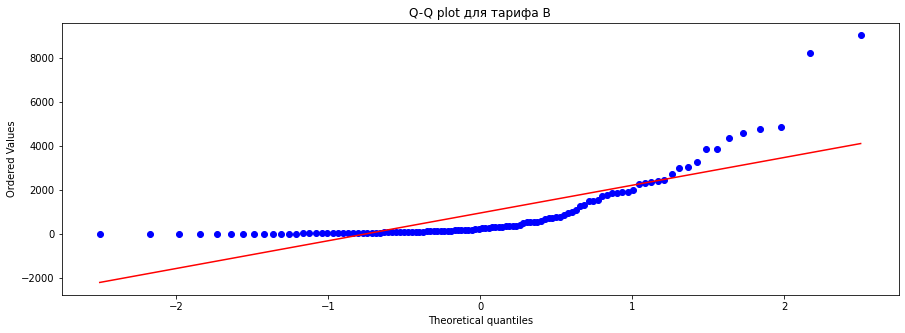

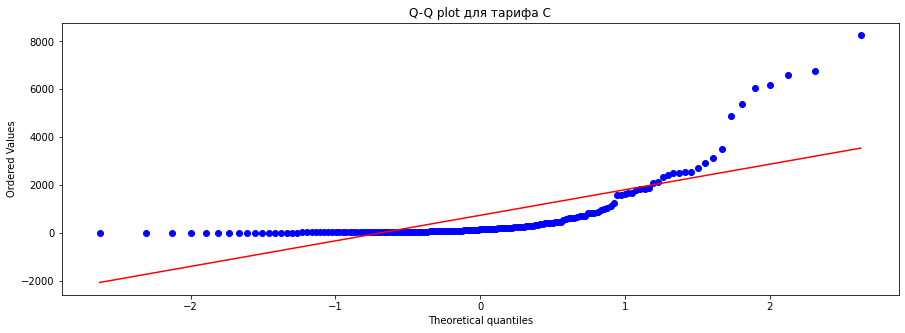

In [ ]:
stats.probplot(data_B, dist="norm", plot=plt)
plt.title("Q-Q plot для тарифа B")
plt.show()
stats.probplot(data_C, dist="norm", plot=plt)
plt.title("Q-Q plot для тарифа C")
plt.show()

In [ ]:
stat_B, p_B = stats.shapiro(data_B)
print(f'Тест Шапиро-Уилка для тарифа A: p-значение = {p_B}')

Тест Шапиро-Уилка для тарифа A: p-значение = 2.8897947775767107e-15


In [ ]:
stat_C, p_C = stats.shapiro(data_C)
print(f'Тест Шапиро-Уилка для тарифа B: p-значение = {p_C}')

Тест Шапиро-Уилка для тарифа B: p-значение = 3.866401479964253e-20


Опять не можем использовать t-test. Ну что ж, значит снова Манна-Уитни:

In [ ]:
stat, p = mannwhitneyu(data_C, data_B, alternative='less')

print(f'Тест Манна-Уитни: p-значение = {p}')

if p > 0.05:
    print("Нет статистически значимых различий между тарифами B и C.")
else:
    print("Есть статистически значимые различия между тарифами B и C.")

Тест Манна-Уитни: p-значение = 0.048870414619598734
Есть статистически значимые различия между тарифами B и C.


Результат вышел близкий. Если бы мы поставил другое aplha, например, 0.01, то уже был бы другой ответ. Все же есть статистическая разница между количеством звонков тарифа B и С, а именно: длительность звонка клиента Тарифа С в среднем меньше, чем клиента тарифа В.

### Выводы по разделу 4

Провели статистические тесты для того, чтобы ответить на гипотезы:
 - Не смогли отвергнуть гипотезу о том, что средний чек клиента тарифа А равен среднему чеку клиента тарифа В. С большой долей вероятности, они действительно равны.
 - Отвергли гипотезу о том, что средняя продолжительность звонков клиентов тарифа В и клиентов тарифа С одинаковая. Отвергли в пользу клиентов тарифа В - у них средняя продолжительность __больше__

## Общий вывод:

### Вывод:

 - __1. Подготовка датафреймов :__ Импортировали нужные библиотеки, создали 2 DataFrame из csv файлов. В первый раз посмотрели на данные
 - __2. Предобработка данных :__ Данные оказались непростыми с точки зрения предобработки. Пришлось потратить много усилий, чтобы собрать информацию, которая не навредит исследования и пригодна для анализа. В ходе самой предобработки:
   - Привели данные к правильным типам
   - Удалили явные дубликаты, посмотрели на неявные, не обнаружили их
   - Разобрались с пропусками
   - Провели большую работу над аномальными значениями. Пришлось отбросить около 25% данных, но они лишь навредили бы исследованию
   - Создали общую таблицу из исходных датафреймов
 - __3. Исследовательский анализ :__ Ответили на основные вопросы исследования, а также на некоторые дополнительные, которые могли появиться, при взгляде на данные:
   - По распределению клиентов по тарифным планам видим явное лидирование тарифа С, так как он самый дешевый. Тариф А находится в явном меньшинстве, что тоже достаточно объяснимо, так как он самый дорогой
   - Клиенты тарифов С звонят чаще и больше, чем даже клиенты на тарифе А. Это как раз может служить одним из факторов того, что они используют невыгодный для них тариф
   - Создали таблицу по пользователям, а также рассмотрели, как искать активных клиентов. Решением стало отделить нижний, 25-ый перцентиль. Это все клиенты, которые за месяц имели меньше 16 звонков
   - Также посмотрели на то, какому количеству пользователей было бы выгодно остаться, а каким переключиться. Оказалось, что:
     - Лишь __18% клиентов__ выгодно __Остаться на текущем тарифе__
     - Большинству клиентов (__45%__) выгодно __Перейти на тариф "выше"__
     - Оставшемуся количеству клиентов (__37%__) выгодно __Перейти на два тарифа "выше"__
   - А также пришли к выводу, что складывается такая ситуация, что если мы не предложим клиентам перейти на другой тариф, то __82%!__ клиентов у нас используют свои тарифы __невыгодно__
   - Создали итоговую таблицу, в которой мы можем найти идентификаторы всех клиентов, кому можно предложить переход и показали выгоду для каждого конкретного клиента
   - Затем рассчитали затраты компании в случае, если __каждый клиент__ перейдет на выгодный для него тариф - около __3 млн рублей__ в среднем за месяц
   - Были предложены варианты уменьшения этой суммы:
     - Оформлять переход за плату. При цене выше, чем 143000 руб., компания будет __в плюсе__
     - Предложить оформить переход только клиентам из самой популярной группы. В таком случае потери компании составят около __2.1 млн рублей__, но также для некоторых клиентов это __будет не самым выгодным предложением для них__
 - __4. Статистический анализ :__ Рассмотрели две гипотезы. Пришли к следующим результатам:
   - Не смогли отвергнуть гипотезу о том, что средний чек клиента тарифа А равен среднему чеку клиента тарифа В. С большой долей вероятности, они действительно равны.
   - Отвергли гипотезу о том, что средняя продолжительность звонков клиентов тарифа В и клиентов тарифа С одинаковая. Отвергли в пользу клиентов тарифа В - у них средняя продолжительность __больше__
 - __5. Общие выводы и рекомендации по итогу анализа :__
   - Проблема неэффективности использования тарифных планов действительно стоит остро и с этим нужно что-то делать
   - Можно использовать предложенные варианты, а также просто предложить всем клиентам перейти на более выгодный тариф без "смягчения" затрат. Если рассматривать альтернативную ситуацию, в которой все "неэффективные" клиенты от нас уйдут, то потери не сильно велики и окупаются буквально за месяц
   - Невозможность отвержения первой гипотезы говорит о том, что параметры тарифов хорошо настроены, что не стоит пытаться менять значения, по которым считается месячный чек

## Презентация для заказчика

Ссылка на презентацию [ТЫК](https://docs.google.com/presentation/d/1tNuDdQ7TnXAk--S6Ejf0Tn4_S-dnKQPkevbEYquem38/edit?usp=sharing)